### Reproducing Will's plots (Gregory et al. 2020) comparing interpolation results to ERA5 snowfall Oct-Apr 2019-2020

### Dataset
- [IS2](#IS2)
- [AK](#AK)
- [CS2_CPOM](#CS2_CPOM)
- [GPOD_Bristol](#GPOD_Bristol)
- [CS2_S3_GPOD](#CS2_S3_GPOD)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.basemap import Basemap
from scipy import stats
import matplotlib as mpl
from scipy.spatial.distance import squareform,pdist,cdist
import scipy.optimize
from netCDF4 import Dataset
from scipy.interpolate import griddata
import pickle
from numpy.linalg import multi_dot as mdot
import glob
import datetime

%matplotlib inline

In [2]:
## long list of all functions used

def readFB(grid_res,season):
    datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
    f = open(datapath1+'dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    FB = pickle.load(f)
    f = open(datapath+'/SIE_masking_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    SIE = pickle.load(f)
    f.close()
    obs = []
    zb = []
    dates = []
    for key in FB:
        obs.append([FB[key]])
        zb.append(SIE[key])
        dates.append(key)
    obs = np.array(obs).transpose(2,3,1,0)
    zb = np.array(zb).transpose(1,2,0)
    zb[zb<0.15] = np.nan
    return obs,zb,dates

def orthoreg(x, y):
    from scipy.stats import linregress
    from scipy.odr import Model, Data, ODR
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.

    Arguments:
    x: x data
    y: y data

    Returns:
    [m, c, nan, nan, nan]

    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    def f(p, x):
        """Basic linear regression 'model' for use with ODR"""
        return (p[0] * x) + p[1]

    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()

    return list(out.beta)

grid_res = 50
season = '2019-2020'
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy')
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy')
lon,lat = m(x,y,inverse=True)

T=9
T_mid=T//2

def download(date):
    datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
    date_split = list(date)
    year = date_split[0]+date_split[1]+date_split[2]+date_split[3]
    month = date_split[4]+date_split[5]
    import shutil
    import urllib.request as request
    from contextlib import closing
    with closing(request.urlopen('ftp://osisaf.met.no//archive/ice/type/'+year+'/'+month+'//ice_type_nh_polstere-100_multi_'+date+'1200.nc')) as r:
        with open(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+date+'1200.nc', 'wb') as f:
            shutil.copyfileobj(r, f)

def icetype():
    datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
    if os.path.exists(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')==False:
        if os.path.exists(datapath+'/icetype')==False:
            os.mkdir(datapath+'/icetype')
        f = open(datapath1+'dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')

        FB_all = pickle.load(f)
        FB_FYI = np.zeros((dX,dY,len(FB_all)))*np.nan
        FB_MYI = np.zeros((dX,dY,len(FB_all)))*np.nan
        icetype_grid = np.zeros((dX,dY,len(FB_all)))*np.nan
        FB_dates = []
        k = 0
        for key in FB_all: #key is a date, so looping through each day for which we have gridded CS2 obs in this season
            print('Downloading OSI-SAF icetype: ',key)
            download(key)
            FB_dates.append(key)
            try:
                FB = FB_all[key]
            except:
                print('KeyError')
            fbFYI = np.zeros((dX,dY))*np.nan
            fbMYI = np.zeros((dX,dY))*np.nan
            icetype = Dataset(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+str(key)+'1200.nc')
            icetype_lon = np.array(icetype['lon'])
            icetype_lat = np.array(icetype['lat'])
            icetype_x,icetype_y = m(icetype_lon,icetype_lat)
            itype = np.array(icetype['ice_type']).astype('float32')[0,:,:]
            itype[itype>3] = np.nan
            itype[itype<2] = np.nan
            icetype_grid[:,:,k] = griddata((icetype_x.ravel(),icetype_y.ravel()),itype.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
            FYI = np.where(icetype_grid[:,:,k]==2)
            MYI = np.where(icetype_grid[:,:,k]==3)
            fbFYI[FYI] = FB[FYI]
            fbMYI[MYI] = FB[MYI]
            FB_FYI[:,:,k] = fbFYI
            FB_MYI[:,:,k] = fbMYI
            k += 1
        np.save(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy',FB_FYI)
        np.save(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy',FB_MYI)
        np.save(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy',icetype_grid)
    else:
        pass

def plots():
    ###plot daily anomalies
    datapath='/Users/carmennab/PhD/OI_PolarSnow/'

    #get grid cells which have been either FYI or MYI for the whole season
    FYI_row = [] ; MYI_row = []
    FYI_col = [] ; MYI_col = []
    for i in range(dX):
        for j in range(dY):
            if (icetype_grid[i,j,:] == 2).all():
                FYI_row.append(i) ; FYI_col.append(j)
            elif (icetype_grid[i,j,:] == 3).all():
                MYI_row.append(i) ; MYI_col.append(j)
    FYI = (FYI_row,FYI_col)
    MYI = (MYI_row,MYI_col)

    datelist=[]

    if SAT in ('IS2','AK','CS2_GPOD_Bristol','S3_GPOD_Bristol'):
        for i, yearmonth in enumerate((201910,201911,201912, 202001, 202002, 202003, 202004)):
            year=int(str(yearmonth)[0:4])
            month=int(str(yearmonth)[4:6])
            days_in_month=(31,30,31,31,29,31,30)

            for Day in range(1,days_in_month[i]+1):

                day = "%02d" % Day
                date=str(yearmonth)+day

                date = datetime.datetime(year, month, Day)
                if day == '01':
                    datelist.append(date.strftime("%-d %b %y"))
                elif day == '15':
                    datelist.append(date.strftime("%-d %b %y"))
                elif ((yearmonth==201904) & (day == '30')):
                    datelist.append(date.strftime("%-d %b %y"))
                else:
                    datelist.append('')     
                    
    elif SAT in ('CS2_CPOM'):
        for i, yearmonth in enumerate((201911,201912, 202001, 202002, 202003)):
            year=int(str(yearmonth)[0:4])
            month=int(str(yearmonth)[4:6])
            days_in_month=(30,31,31,29,31)

            for Day in range(1,days_in_month[i]+1):

                day = "%02d" % Day
                date=str(yearmonth)+day

                date = datetime.datetime(year, month, Day)
                if day == '01':
                    datelist.append(date.strftime("%-d %b %y"))
                elif day == '15':
                    datelist.append(date.strftime("%-d %b %y"))
                elif ((yearmonth==202004) & (day == '30')):
                    datelist.append(date.strftime("%-d %b %y"))
                else:
                    datelist.append('')  
    
    elif SAT in ('CS2_S3_GPOD'):
        for i, yearmonth in enumerate((201911,201912, 202001, 202002, 202003, 202004)):
            year=int(str(yearmonth)[0:4])
            month=int(str(yearmonth)[4:6])
            days_in_month=(30,31,31,29,31,30)

            for Day in range(1,days_in_month[i]+1):

                day = "%02d" % Day
                date=str(yearmonth)+day

                date = datetime.datetime(year, month, Day)
                if day == '01':
                    datelist.append(date.strftime("%-d %b %y"))
                elif day == '15':
                    datelist.append(date.strftime("%-d %b %y"))
                elif ((yearmonth==201904) & (day == '30')):
                    datelist.append(date.strftime("%-d %b %y"))
                else:
                    datelist.append('') 
        
    interp_mean = np.zeros((2,len(files)))
    era5_mean = np.zeros((2,len(files)))
    zones = [FYI,MYI]
    for day in range(len(files)):
        if SAT in ('CS2_GPOD_Bristol', 'S3_GPOD_Bristol'):
            stamp = files[day].split('/')[-1].split('_')[5][0:8]
        else:
            stamp = files[day].split('/')[-1].split('_')[4][0:8]
        try:
            ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
        except:
            ERA5 = Dataset(datapath+'ERA5/daily-sf_'+str(int(stamp)-1)+'.nc')
        snow = np.array(ERA5['sf'])[0,:161,:] #i think 161 was the index which marked 60 degree latitude boundary
        era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
        era5_x,era5_y = m(era5_lon,era5_lat)
        snow = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
        for k in range(2):
            a = fb[:,:,day][zones[k]] ; b = snow[zones[k]]
            ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
            interp_mean[k,day] = np.nanmean(a[ID])
            #print(interp_mean[k,day])
            # I manually removed the interpolated files with only NaN values (most of april) bc couldn't figure out how to code it here, but they're still on the server if we need them
            era5_mean[k,day] = np.nanmean(b[ID])

    fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
    colors = ['crimson','purple']
    ylims = [[-1.5,1.5],[-4.0,3.2]]
    ylims2 = [[-0.01,0.15],[-0.05,0.22]]
    labels = ['FYI','MYI']
    end = [1,2]
    for k in range(2):
        ax[k].spines['top'].set_color('none')
        ax[k].spines['right'].set_color('none')
        p = np.polyfit(np.arange(len(files)),interp_mean[k,:],2)
        anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
        snow = era5_mean[k,:]*100
        #anomalies = interp_mean[k,:]*5
        r = (stats.pearsonr(anomalies,snow)[0]).round(2)
        ylim = ylims[k]
        ax[k].plot(anomalies,colors[k],lw=2)
        ax[k].set_xticks(np.arange(len(datelist)))
        ax[k].set_xticklabels(datelist)
        ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
        ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
        ax[k].set_ylabel(SAT+' freeboard anomalies (cm)',labelpad=10,fontsize=16)
        ax[k].set_ylim(ylim)
        ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
        ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
        ax[k].yaxis.label.set_color(colors[k])
        ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
        ax[k].tick_params(axis='y', colors=colors[k])
        ax2 = ax[k].twinx()
        ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
        ax2.set_ylabel('ERA5 snowfall (cm SWE)',labelpad=10,fontsize=16)
        ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
        ax2.set_ylim(ylims2[k])
        if k == 1:
            ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

        for i in range(len(datelist)):
        # If there is a label, plot a tick:
            if len(datelist[i]) > 0:
                # Plot grey grid line
                ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
                # Plot black tick
                ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

    plt.subplots_adjust(hspace=0.2)
    plt.show()

    ###plot 9 day running mean
    datapath='/Users/carmennab/PhD/OI_PolarSnow/'
    
    FYI_row = [] ; MYI_row = []
    FYI_col = [] ; MYI_col = []
    for i in range(dX):
        for j in range(dY):
            if (icetype_grid[i,j,:] == 2).all():
                FYI_row.append(i) ; FYI_col.append(j)
            elif (icetype_grid[i,j,:] == 3).all():
                MYI_row.append(i) ; MYI_col.append(j)
    FYI = (FYI_row,FYI_col)
    MYI = (MYI_row,MYI_col)

    itype_mask = np.zeros((160,160))*np.nan
    itype_mask[FYI] = 1
    itype_mask[MYI] = 0
    
    snows = np.zeros((160,160,len(files)))
    for day in range(len(files)):
        if SAT in ('CS2_GPOD_Bristol', 'S3_GPOD_Bristol'):
            stamp = files[day].split('/')[-1].split('_')[5][0:8]
        else:
            stamp = files[day].split('/')[-1].split('_')[4][0:8]
        try:
            ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
        except:
            ERA5 = Dataset(datapath+'ERA5/daily-sf_'+str(int(stamp)-1)+'.nc')
        snow = np.array(ERA5['sf'])[0,:161,:]
        era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
        era5_x,era5_y = m(era5_lon,era5_lat)
        snows[:,:,day] = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')

    zones = [FYI,MYI]
    for day in range(len(files)):
        if (day >= 4) & (day <= 140):
            freeboard = np.nanmean(fb[:,:,day-4:day+5],2)
            snow_total = np.nansum(snows[:,:,day-4:day+5],2)
            for k in range(2):
                a = freeboard[zones[k]] ; b = snow_total[zones[k]]
                ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
                interp_mean[k,day] = np.nanmean(a[ID])
                era5_mean[k,day] = np.nanmean(b[ID])         

    fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
    colors = ['crimson','purple']
    ylims = [[-1.5,1.5],[-3.5,3.2]]
    ylims2 = [[0.0,1.0],[0.0,1.0]]
    labels = ['FYI','MYI']
    end = [1,2]
    for k in range(2):
        ax[k].spines['top'].set_color('none')
        ax[k].spines['right'].set_color('none')
        p = np.polyfit(np.arange(len(files)),interp_mean[k,:],2)
        anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
        snow = era5_mean[k,:]*100
        #anomalies = interp_mean[k,:]*5
        r = (stats.pearsonr(anomalies,snow)[0]).round(2)
        ylim = ylims[k]
        ax[k].plot(anomalies,colors[k],lw=2)
        ax[k].set_xticks(np.arange(len(datelist)))
        ax[k].set_xticklabels(datelist)
        ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
        ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
        ax[k].set_ylabel(SAT+' laser freeboard anomalies (cm)',labelpad=10,fontsize=16)
        ax[k].set_ylim(ylim)
        ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
        ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
        ax[k].yaxis.label.set_color(colors[k])
        ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
        ax[k].tick_params(axis='y', colors=colors[k])
        ax2 = ax[k].twinx()
        ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
        ax2.set_ylabel('ERA5 9-day snowfall acc (cm SWE)',labelpad=10,fontsize=16)
        ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
        ax2.set_ylim(ylims2[k])

        for i in range(len(datelist)):
        # If there is a label, plot a tick:
            if len(datelist[i]) > 0:
                # Plot grey grid line
                ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
                # Plot black tick
                ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

# IS2

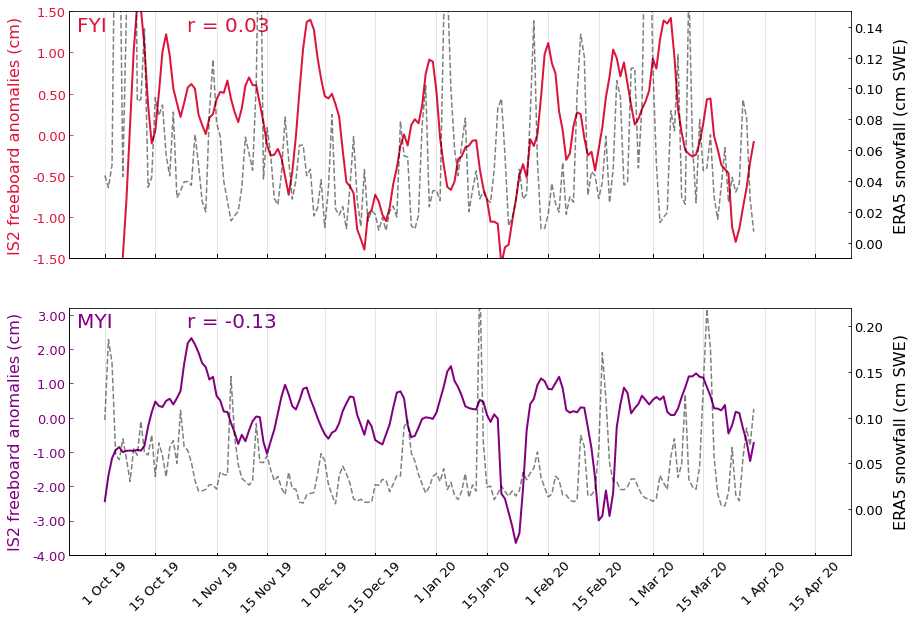

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_11626/2673344827.py:305: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


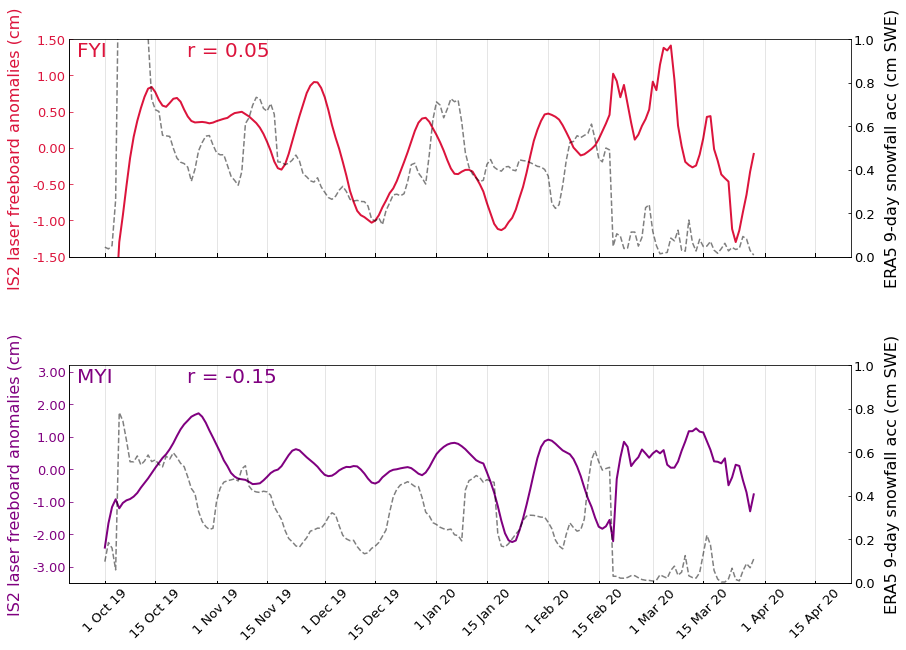

In [3]:
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/IS2/'
SAT = 'IS2'
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]
icetype() 

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
FB_FYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy')
FB_MYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy')
icetype_grid = np.load(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/Data/IS2/'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))

IS2_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[7]
    date2 = date1.split('.')
    date=date2[0]
    IS2_interp[date]= np.load(datapath+'FB_interp_2019-2020_50km_'+str(date)+'.npy')

fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[4][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

plots()

# AK

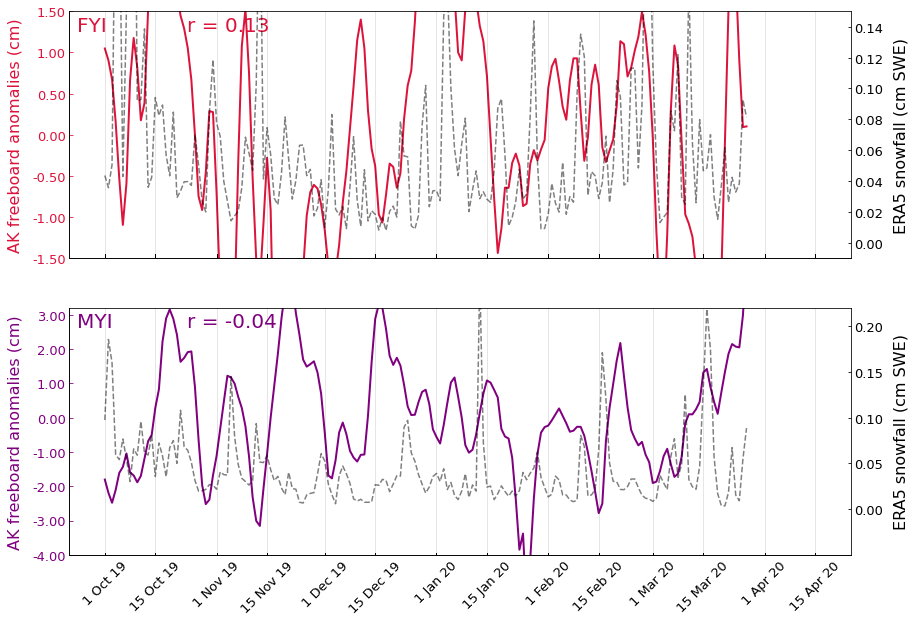

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_11626/2673344827.py:305: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


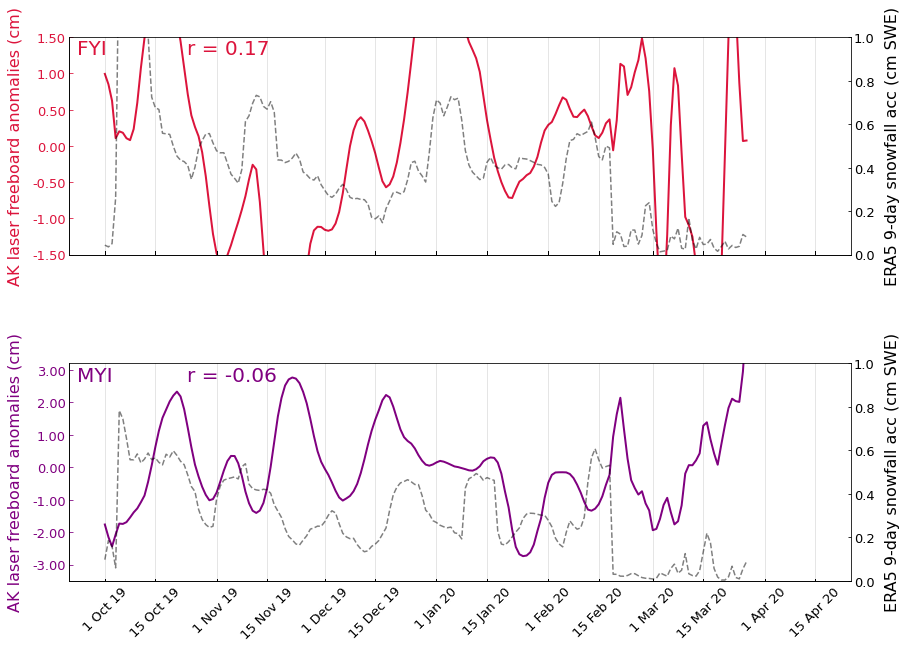

In [4]:
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/AK/'
SAT = 'AK'
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]
icetype() 

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
FB_FYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy')
FB_MYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy')
icetype_grid = np.load(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')


datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/AK/'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))

AK_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[7]
    date2 = date1.split('.')
    date=date2[0]
    AK_interp[date]= np.load(datapath+'FB_interp_2019-2020_50km_'+str(date)+'.npy')

fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[4][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

plots()

# CS2_CPOM

October and April data not available

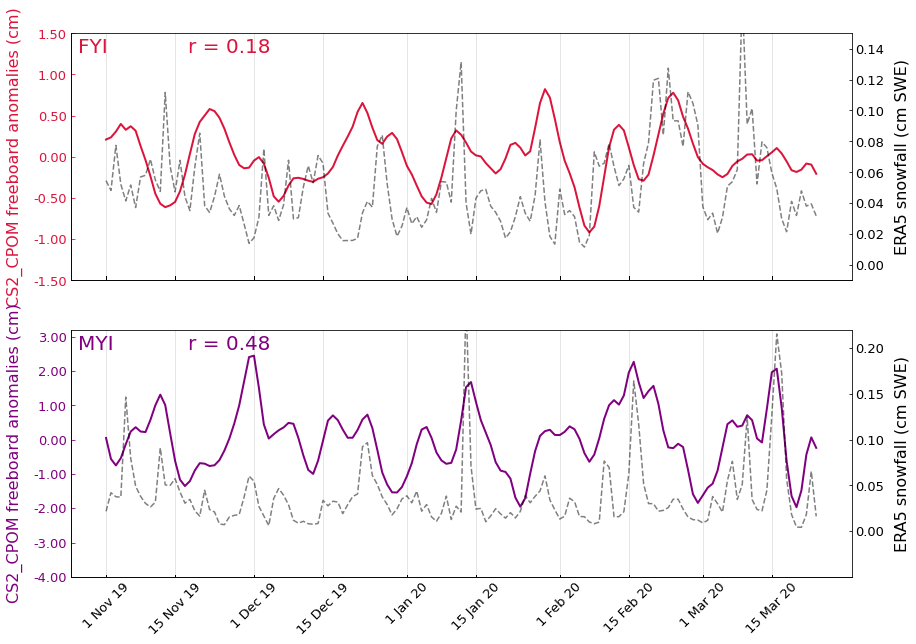

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_11626/2673344827.py:305: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


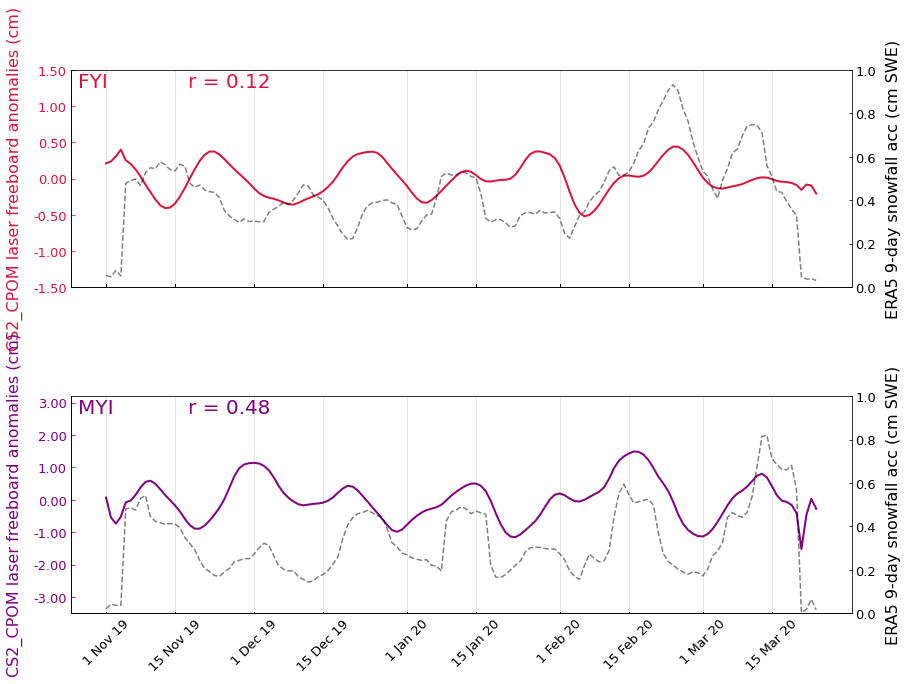

In [5]:
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/CS2_CPOM/'
SAT = 'CS2_CPOM'
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]
icetype() 

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
FB_FYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy')
FB_MYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy')
icetype_grid = np.load(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/Data/CS2_CPOM/'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))

CS2_CPOM_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[8]
    date2 = date1.split('.')
    date=date2[0]
    CS2_CPOM_interp[date]= np.load(datapath+'FB_interp_2019-2020_50km_'+str(date)+'.npy')

fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[4][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

plots()

# GPOD_Bristol

CS2

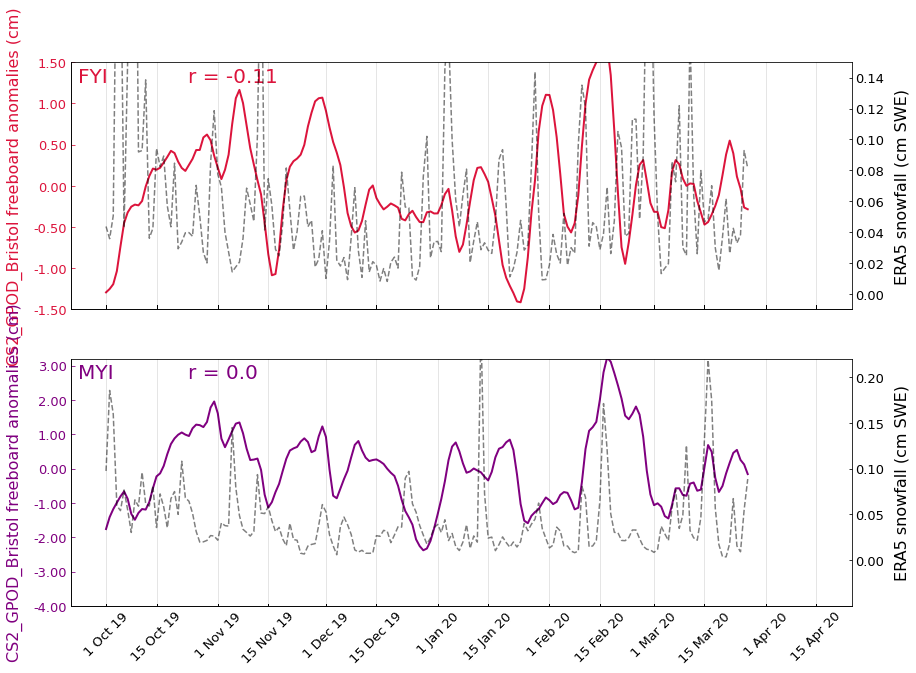

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_11626/2673344827.py:305: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


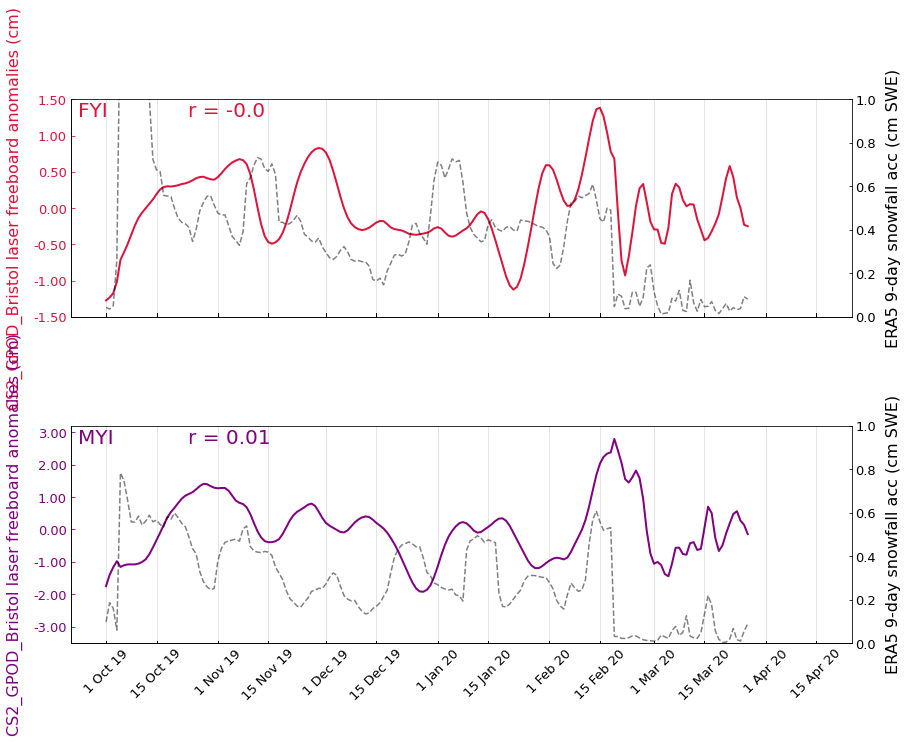

In [6]:
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/GPOD_Bristol/CS2_GPOD_Bristol_'
SAT = 'CS2_GPOD_Bristol'
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]
icetype() 

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
FB_FYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy')
FB_MYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy')
icetype_grid = np.load(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/GPOD_Bristol/CS2_'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))

CS2_GPOD_Bristol_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[9]
    date2 = date1.split('.')
    date=date2[0]
    CS2_GPOD_Bristol_interp[date]= np.load(datapath+'FB_interp_2019-2020_50km_'+str(date)+'.npy')

fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[5][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

plots()

S3

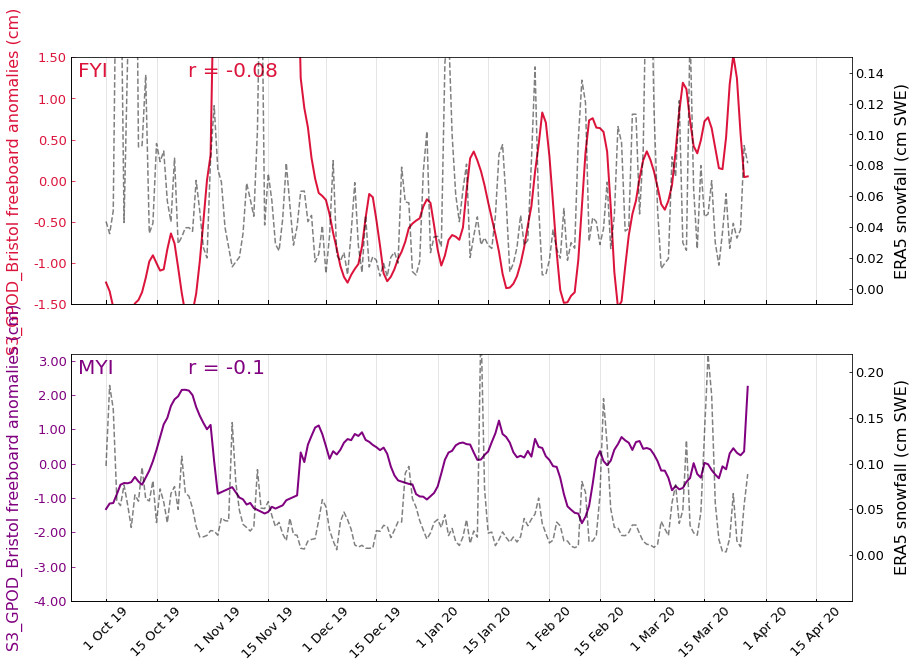

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_11626/2673344827.py:305: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


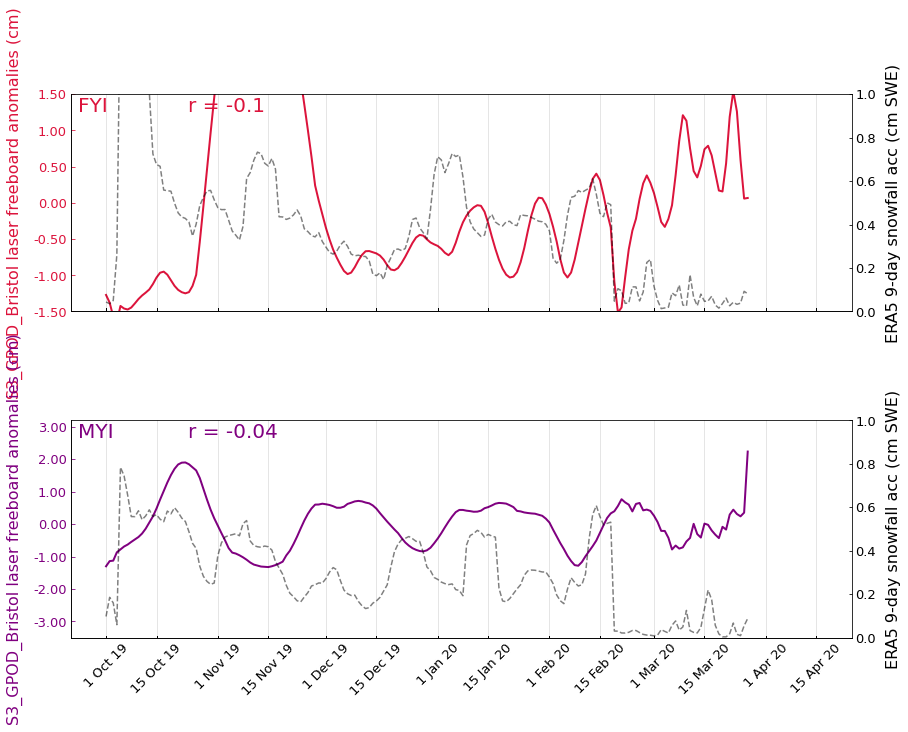

In [7]:
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/GPOD_Bristol/S3_GPOD_Bristol_'
SAT = 'S3_GPOD_Bristol'
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]
icetype() 

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
FB_FYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy')
FB_MYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy')
icetype_grid = np.load(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/Data/GPOD_Bristol/'
files = sorted(glob.glob(datapath+'S3_FB_interp_'+season+'_50km_*.npy'))

S3_GPOD_Bristol_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[9]
    date2 = date1.split('.')
    date=date2[0]
    S3_GPOD_Bristol_interp[date]= np.load(datapath+'S3_FB_interp_2019-2020_50km_'+str(date)+'.npy')

fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[5][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

plots()

# CS2_S3_GPOD

In [8]:
# function but with merged along-track data

def readFB_merged(grid_res,season):
    datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
    f = open(datapath1+'/CS2_SAR_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    CS2_SAR = pickle.load(f)
    f = open(datapath1+'/CS2_SARIN_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    CS2_SARIN = pickle.load(f)
    f = open(datapath1+'/S3A_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    S3A= pickle.load(f)
    f = open(datapath1+'/S3B_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    S3B = pickle.load(f)
    f = open(datapath+'/SIE_masking_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    SIE = pickle.load(f)
    f.close()
    obs = []
    zb = []
    dates = []
    for key in CS2_SAR:
        if (key in CS2_SARIN) & (key in S3A) & (key in S3B):
            obs.append([CS2_SAR[key],CS2_SARIN[key],S3A[key],S3B[key]])
            zb.append(SIE[key])
            dates.append(key)
    obs = np.array(obs).transpose(2,3,1,0)
    zb = np.array(zb).transpose(1,2,0)
    zb[zb<0.15] = np.nan
    return obs,zb,dates


def icetype():
    datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
    if os.path.exists(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')==False:
        if os.path.exists(datapath+'/icetype')==False:
            os.mkdir(datapath+'/icetype')
        f = open(datapath1+'/CS2_SAR_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
        CS2_SAR = pickle.load(f)
        f = open(datapath1+'/CS2_SARIN_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
        CS2_SARIN = pickle.load(f)
        f = open(datapath1+'/S3A_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
        S3A= pickle.load(f)
        f = open(datapath1+'/S3B_dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
        S3B = pickle.load(f)

        FB_FYI = np.zeros((dX,dY,len(CS2_SAR)))*np.nan
        FB_MYI = np.zeros((dX,dY,len(CS2_SAR)))*np.nan
        icetype_grid = np.zeros((dX,dY,len(CS2_SAR)))*np.nan
        FB_dates = []
        k = 0    
        
        for key in CS2_SAR: #key is a date, so looping through each day for which we have gridded CS2 obs in this season
            print('Downloading OSI-SAF icetype: ',key)
            download(key)
            FB_dates.append(key)
            try:
                FB = CS2_SAR[key]
            except:
                print('KeyError')
            fbFYI = np.zeros((dX,dY))*np.nan
            fbMYI = np.zeros((dX,dY))*np.nan
            icetype = Dataset(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+str(key)+'1200.nc')
            icetype_lon = np.array(icetype['lon'])
            icetype_lat = np.array(icetype['lat'])
            icetype_x,icetype_y = m(icetype_lon,icetype_lat)
            itype = np.array(icetype['ice_type']).astype('float32')[0,:,:]
            itype[itype>3] = np.nan
            itype[itype<2] = np.nan
            icetype_grid[:,:,k] = griddata((icetype_x.ravel(),icetype_y.ravel()),itype.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
            FYI = np.where(icetype_grid[:,:,k]==2)
            MYI = np.where(icetype_grid[:,:,k]==3)
            fbFYI[FYI] = FB[FYI]
            fbMYI[MYI] = FB[MYI]
            FB_FYI[:,:,k] = fbFYI
            FB_MYI[:,:,k] = fbMYI
            k += 1
        np.save(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy',FB_FYI)
        np.save(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy',FB_MYI)
        np.save(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy',icetype_grid)
    else:
        pass

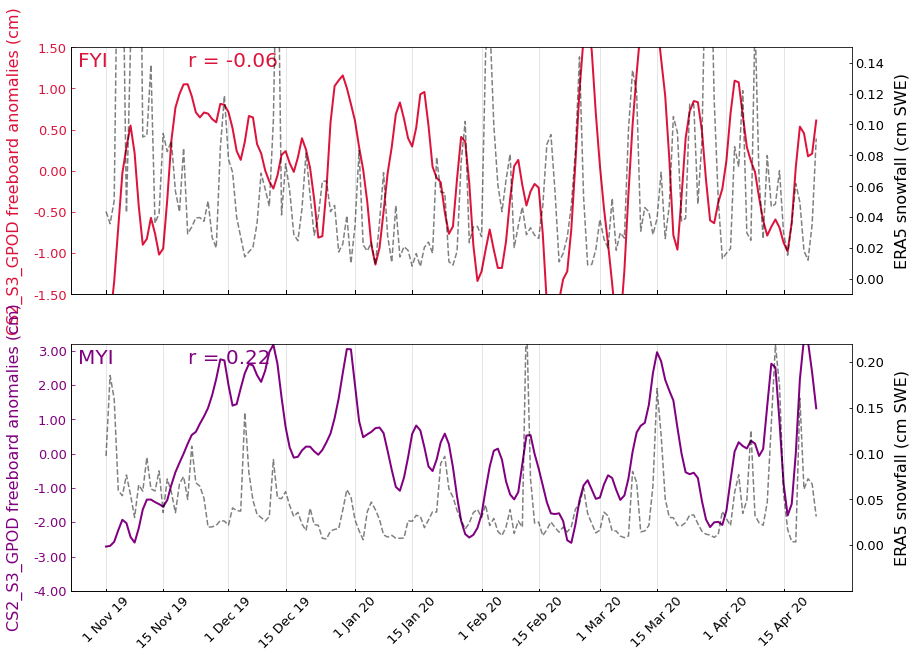

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_11626/2673344827.py:305: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


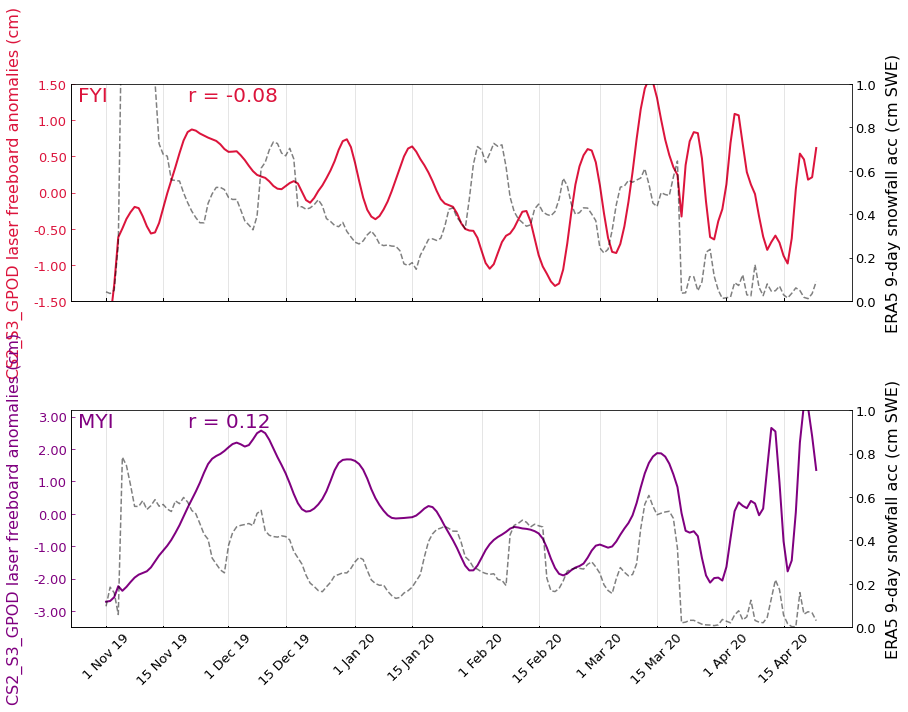

In [9]:
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/CS2_S3_GPOD'
SAT = 'CS2_S3_GPOD'
obs,zb,dates = readFB_merged(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]
icetype() 

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
FB_FYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_FYI_Oct2019_Apr2020_'+season+'.npy')
FB_MYI = np.load(datapath+'/'+str(SAT)+'_'+str(grid_res)+'km_MYI_Oct2019_Apr2020_'+season+'.npy')
icetype_grid = np.load(datapath+'/icetype_'+str(SAT)+str(grid_res)+'km_Oct2019_Apr2020_'+season+'.npy')

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_S3_GPOD/'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))

CS2_S3_GPOD_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[9]
    date2 = date1.split('.')
    date=date2[0]
    CS2_S3_GPOD_interp[date]= np.load(datapath+'FB_interp_2019-2020_50km_'+str(date)+'.npy')

fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[4][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

plots()